# Merge de los datos del socib con los datos con pH

Merge por fechas unicas y matching por similitud con distancia eucliea para el resto de variables, con ponderacion para dar mas peso a profundidad y presion.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

def merge_matching_unico_ponderado(df_socib, df_ph, variables_comunes, columnas_a_agregar, pesos=None):
    df_socib = df_socib.copy()
    df_ph = df_ph.copy()

    df_socib['DATE'] = pd.to_datetime(df_socib['DATE'])
    df_ph['DATE'] = pd.to_datetime(df_ph['DATE'])

    for col in columnas_a_agregar:
        if col not in df_socib.columns:
            df_socib[col] = np.nan

    for var in variables_comunes:
        col_ph = var + '_ph'
        if col_ph not in df_socib.columns:
            df_socib[col_ph] = np.nan

    fechas_socib = set(df_socib['DATE'])
    fechas_ph = set(df_ph['DATE'])
    fechas_comunes = fechas_socib & fechas_ph
    fechas_solo_ph = fechas_ph - fechas_socib

    if pesos is None:
        pesos = {var: 1.0 for var in variables_comunes}
    pesos_vector = np.array([pesos.get(var, 1.0) for var in variables_comunes])

    for fecha in fechas_comunes:
        sub_socib = df_socib[df_socib['DATE'] == fecha].copy()
        sub_ph = df_ph[df_ph['DATE'] == fecha].copy()

        if sub_socib.empty or sub_ph.empty:
            continue

        scaler = StandardScaler()
        socib_vals = scaler.fit_transform(sub_socib[variables_comunes])
        ph_vals = scaler.transform(sub_ph[variables_comunes])

        # Aplicar pesos: multiplico cada variable por la raíz cuadrada del peso
        socib_vals_weighted = socib_vals * np.sqrt(pesos_vector)
        ph_vals_weighted = ph_vals * np.sqrt(pesos_vector)

        dist_matrix = cdist(socib_vals_weighted, ph_vals_weighted, metric='euclidean')

        row_ind, col_ind = linear_sum_assignment(dist_matrix)

        for i, j in zip(row_ind, col_ind):
            idx_socib = sub_socib.index[i]
            fila_ph = sub_ph.iloc[j]

            for col in columnas_a_agregar:
                df_socib.at[idx_socib, col] = fila_ph[col]
            for var in variables_comunes:
                df_socib.at[idx_socib, var + '_ph'] = fila_ph[var]

    nuevos_registros = df_ph[df_ph['DATE'].isin(fechas_solo_ph)].copy()
    columnas_faltantes = [col for col in df_socib.columns if col not in nuevos_registros.columns]
    for col in columnas_faltantes:
        nuevos_registros[col] = np.nan

    df_final = pd.concat([df_socib, nuevos_registros[df_socib.columns]], ignore_index=True)
    return df_final

In [2]:
variables_comunes = ['WTR_TEM_01','WTR_PRE', 'SALT', 'OXI_CON', 'DEPTH', 'CHLO', 'COND']
columnas_a_agregar = ['pH', 'pH Accuracy', 'pH Precision', 'Spar']


datos_socib = pd.read_csv("datos_socib_clean_complete_11_09.csv")
datos_ph = pd.read_csv("datos_con_ph_11_09_25.csv")

pesos = {'DEPTH': 1000, 'WTR_PRE': 1000}
df_merged_unico = merge_matching_unico_ponderado(datos_socib, datos_ph, variables_comunes, columnas_a_agregar, pesos=pesos)

# Evaluacion del merge

In [3]:
from scipy.stats import ks_2samp

# Variables a comparar
variables = [ 'OXI_CON', 'CHLO', 'COND', 'SALT', 'WTR_TEM_01', 'WTR_PRE', 'TURB', 'DEPTH']

df_merged_nonan = df_merged_unico[df_merged_unico['pH'].notna()]

for var in variables:
    var_ph = f"{var}_ph" if f"{var}_ph" in datos_ph.columns else var

    if var_ph in datos_ph.columns and var in df_merged_unico.columns:
        sample_orig = datos_ph[var_ph].dropna()
        sample_merged = df_merged_nonan[var].dropna()

        ks_stat, p_value = ks_2samp(sample_orig, sample_merged)
        print(f"KS test para {var}: Estadístico={ks_stat:.4f}, p-valor={p_value:.4f}")
        if p_value < 0.05:
            print(" -> Diferencia significativa entre distribuciones (rechazamos H0)")
        else:
            print(" -> No se rechaza H0 (distribuciones similares)")
        print('-' * 40)

KS test para OXI_CON: Estadístico=0.0784, p-valor=0.3056
 -> No se rechaza H0 (distribuciones similares)
----------------------------------------
KS test para CHLO: Estadístico=0.0845, p-valor=0.2288
 -> No se rechaza H0 (distribuciones similares)
----------------------------------------
KS test para COND: Estadístico=0.0547, p-valor=0.7450
 -> No se rechaza H0 (distribuciones similares)
----------------------------------------
KS test para SALT: Estadístico=0.0522, p-valor=0.7919
 -> No se rechaza H0 (distribuciones similares)
----------------------------------------
KS test para WTR_TEM_01: Estadístico=0.0610, p-valor=0.6160
 -> No se rechaza H0 (distribuciones similares)
----------------------------------------
KS test para WTR_PRE: Estadístico=0.0953, p-valor=0.1274
 -> No se rechaza H0 (distribuciones similares)
----------------------------------------
KS test para TURB: Estadístico=0.1237, p-valor=0.0198
 -> Diferencia significativa entre distribuciones (rechazamos H0)
----------

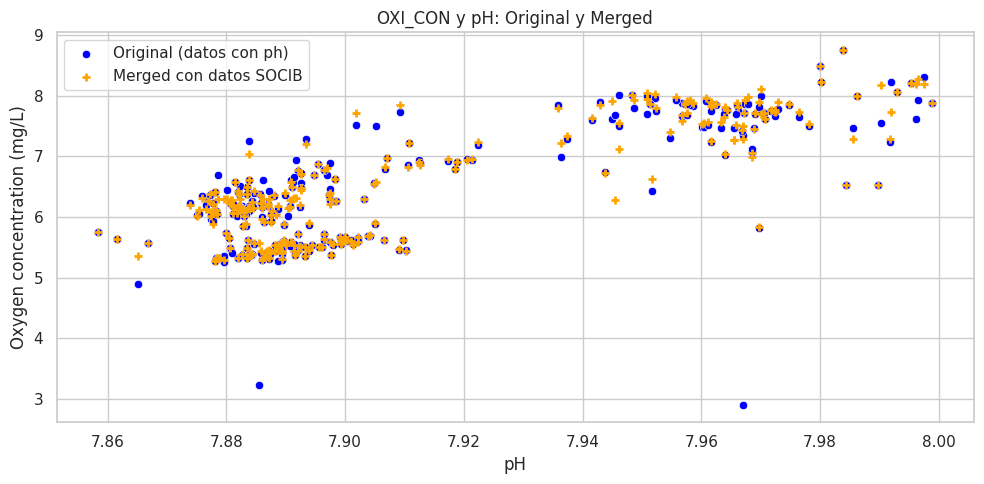

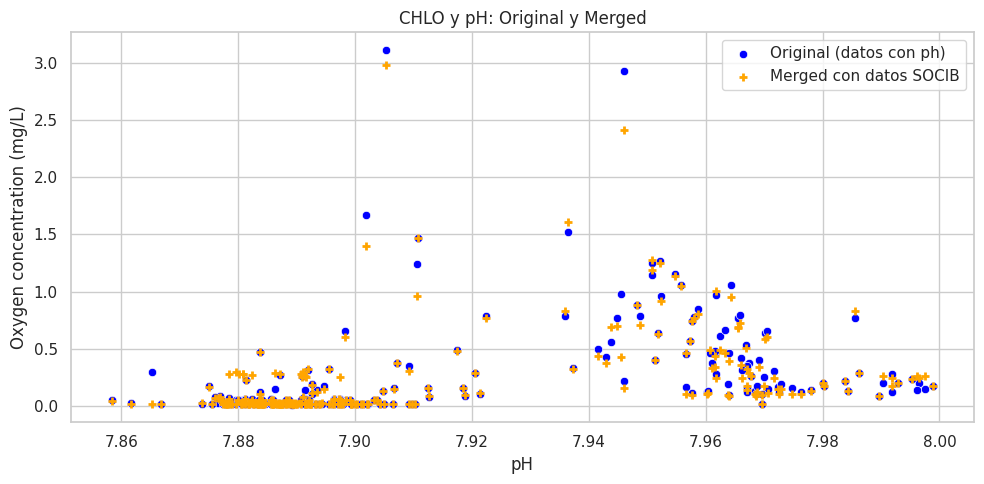

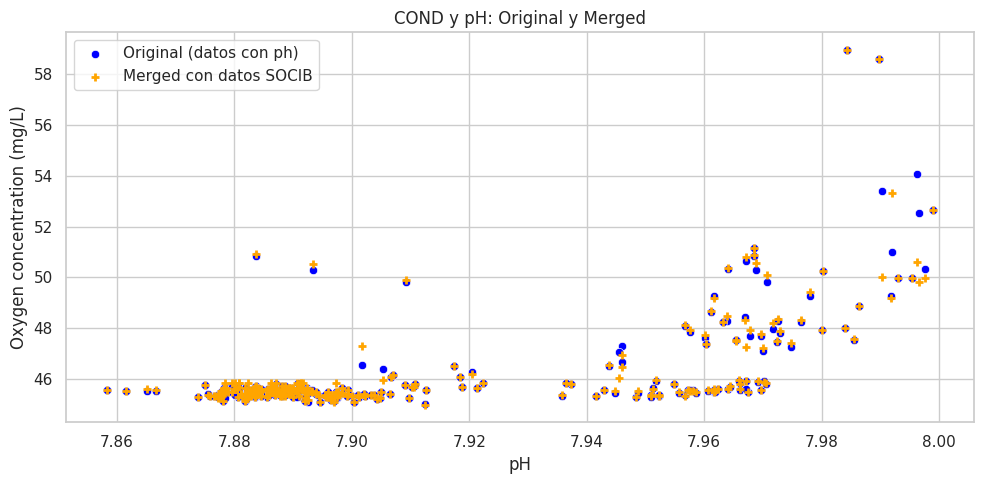

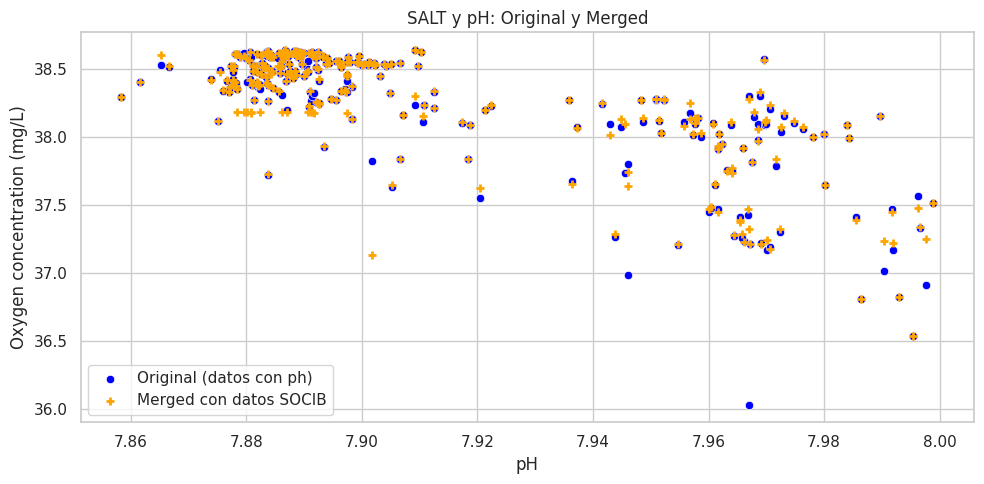

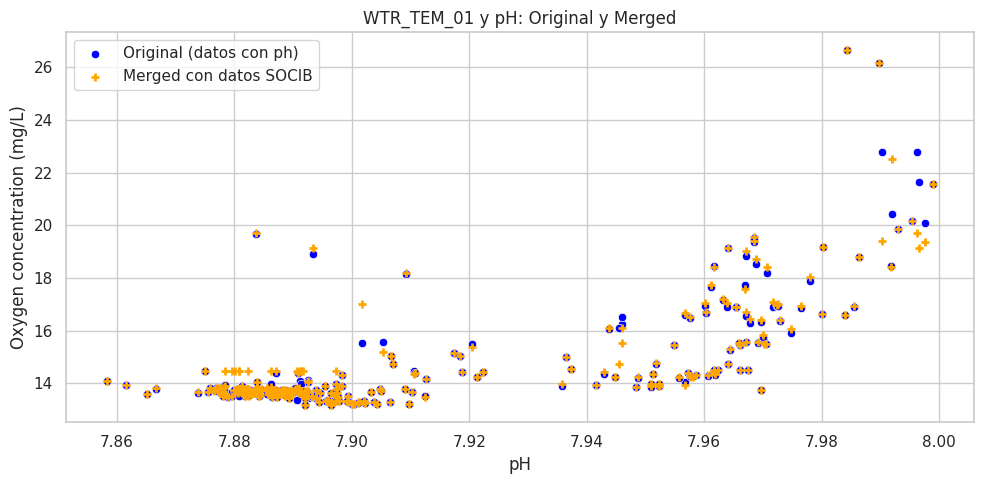

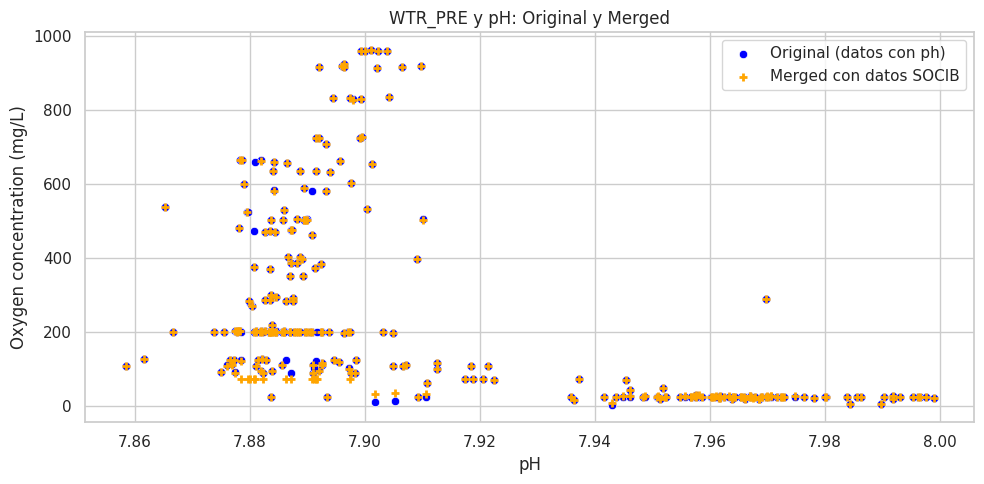

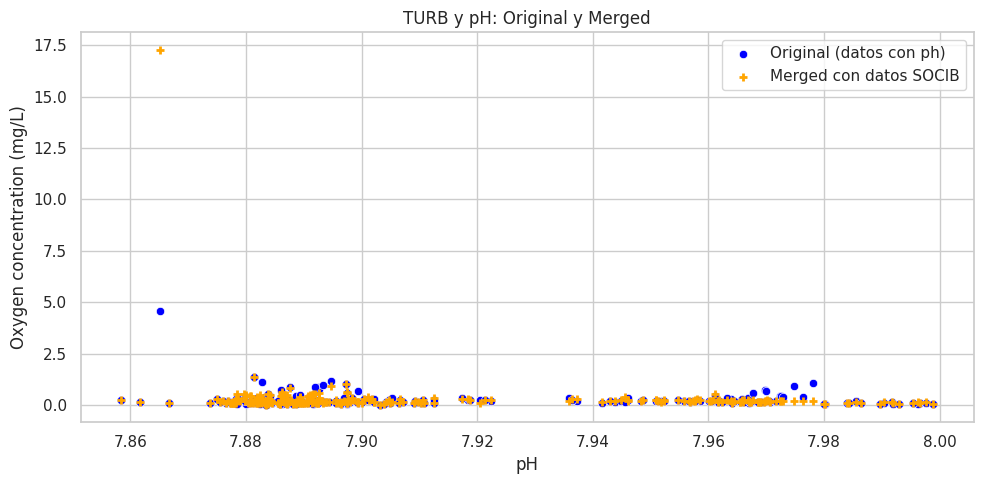

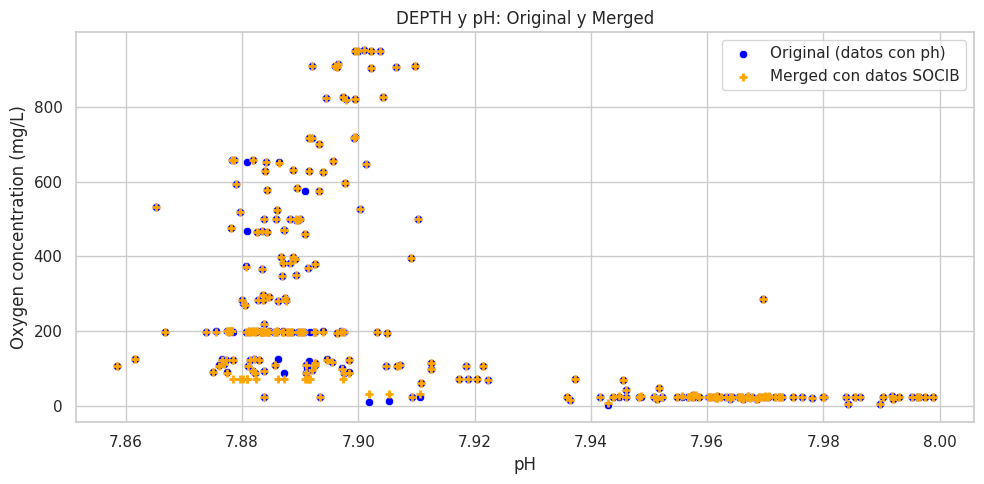

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables a comparar con pH
variables = ['SDPAR', 'OXI_CON', 'CHLO', 'COND', 'SALT', 'WTR_TEM_01', 'WTR_PRE', 'TURB', 'DEPTH']

sns.set(style="whitegrid")

for var in variables:
    var_ph = f"{var}_ph" if f"{var}_ph" in datos_ph.columns else var

    if var_ph in datos_ph.columns and var in df_merged_unico.columns:
        plt.figure(figsize=(10, 5))

        # datos pH
        sns.scatterplot(
            data=datos_ph, x='pH', y=datos_ph[var_ph],
            label='Original (datos con ph)',
            color='blue', alpha=1,
            marker='o'
        )

        # datos merged
        sns.scatterplot(
            data=df_merged_unico[df_merged_unico['pH'].notna()], x='pH', y=df_merged_unico[var],
            label='Merged con datos SOCIB',
            color='orange', alpha=1,
            marker='+', linewidths=2
        )

        plt.title(f'{var} y pH: Original y Merged')
        plt.xlabel('pH')
        plt.ylabel('Oxygen concentration (mg/L)')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Creacion del csv

In [ ]:
df_merged_unico.to_csv("datos_merge_date_euclidea_11_09.csv", index=False)